In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from kneed import KneeLocator
import numpy as np

In [2]:
data = pd.read_csv('Mall_Customers.csv')
data = data.rename({'Genre': 'Gender'}, axis=1)
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


- There are no null values.

In [3]:
data.info()
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

In [4]:
data.nunique()

CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

---
<b>Exploratory Data Analysis<b>

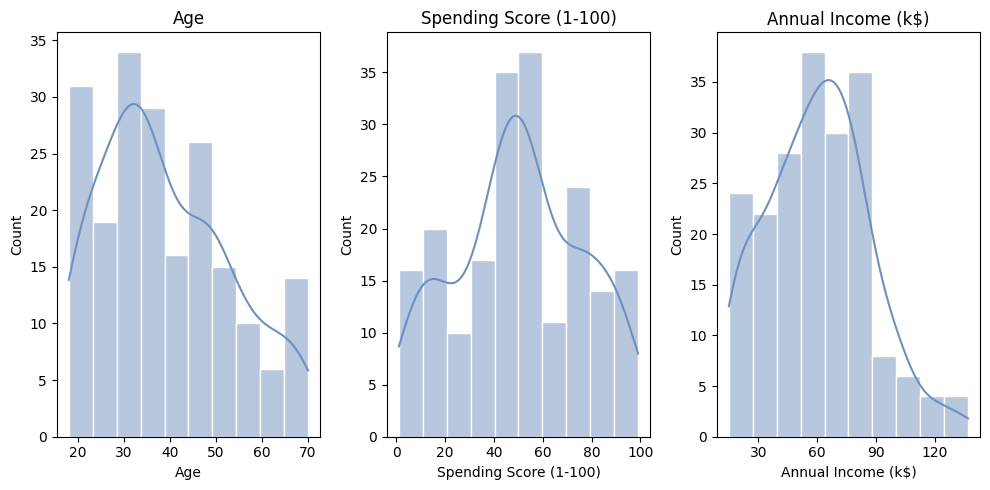

In [5]:
# display(sns.color_palette("vlag"))
col = sns.color_palette("vlag")[0]
targets = ['Age', 'Spending Score (1-100)', 'Annual Income (k$)']

figure, axis = plt.subplots(1, 3, figsize=(10, 5))
n_ticker = 10
for i in range(3):
    target_x = targets[i]
    p = sns.histplot(data=data, x=target_x, kde=True, color=col, edgecolor='white', ax=axis[i], bins=10)
    axis[i].set_title(target_x)
    p.xaxis.set_major_locator(ticker.MultipleLocator(n_ticker))
    p.xaxis.set_major_formatter(ticker.ScalarFormatter())
    n_ticker += 10

plt.tight_layout()
plt.show()

<b>Distributions of the features<b>
- Age (right-skewed distribution)
- Spending Score (Normal distribution)
- Annual income (right-skewed distribution)

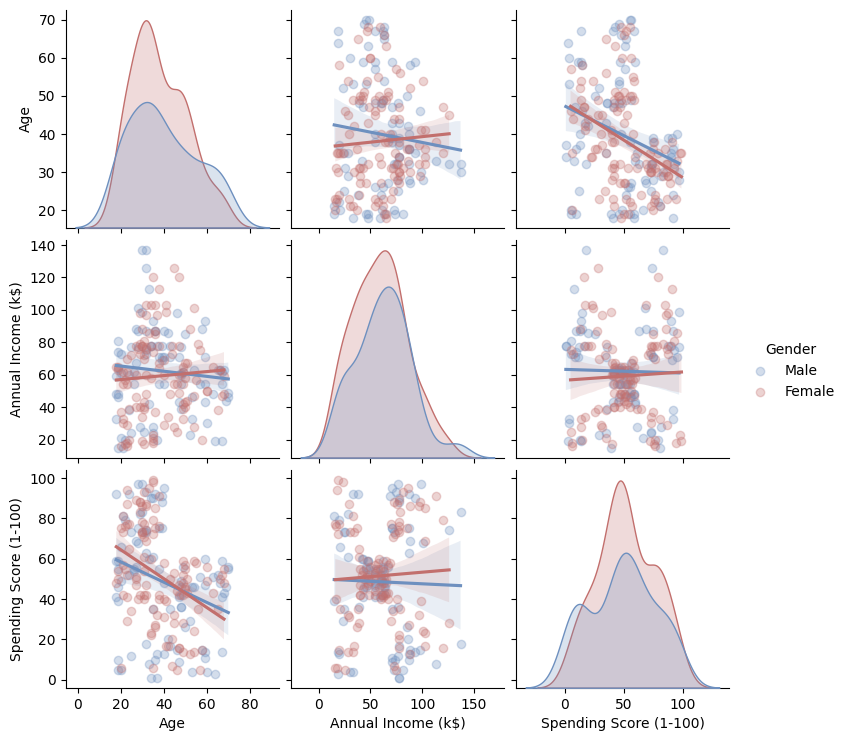

In [6]:
df_pairplot = data[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
sns.pairplot(df_pairplot, kind='reg', hue='Gender', 
             palette = [sns.color_palette("vlag")[0], sns.color_palette("vlag")[-1]], 
             plot_kws={'scatter_kws': {'alpha': 0.3}})

Since not much information can be told, we may consider data transformation (e.g. logarithm) if further analysis (e.g. regression analysis) is needed. 

Following the lowest level of population groups stated by the Australian Bureau of Statistics (2014), 

In [7]:
# Age categories
Age_gps = ['15-24', '25-44', '45-64', '>=65']
df_age = data['Age']
data['15-24']=(df_age>=15)*(df_age <= 24)*1
data['25-44']=(df_age>=25)*(df_age <= 44)*2
data['45-64']=(df_age>=45)*(df_age <= 64)*3
data['>=65']=(df_age>=65)*4
data['Age_gps'] = data['15-24']+data['25-44']+data['45-64']+data['>=65']
for i in range(4):
    data.loc[data['Age_gps'] == (i+1), 'Age_cat'] = Age_gps[i]

data = data.drop(Age_gps+['Age_gps'], axis=1)
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_cat
0,1,Male,19,15,39,15-24
1,2,Male,21,15,81,15-24
2,3,Female,20,16,6,15-24
3,4,Female,23,16,77,15-24
4,5,Female,31,17,40,25-44


<Axes: >

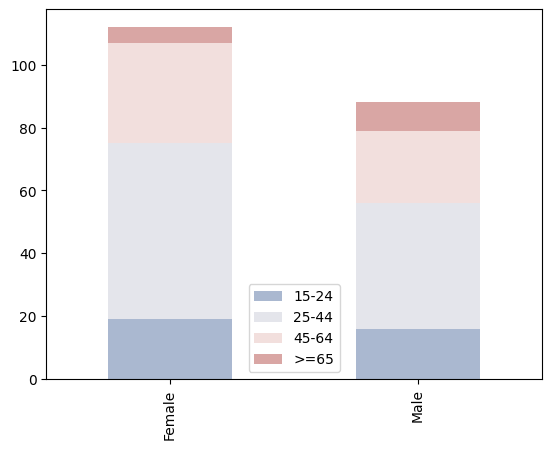

In [8]:
d = data.groupby(['Gender', 'Age_cat'])['Age'].count().reset_index()
gender_age = pd.DataFrame({'Female': d.iloc[0:4,2].values, 
                           'Male':d.iloc[4:8,2].values})
gender_age.index = Age_gps
gender_age.T.plot(kind='bar', stacked=True, color=sns.color_palette("vlag")[1:5])

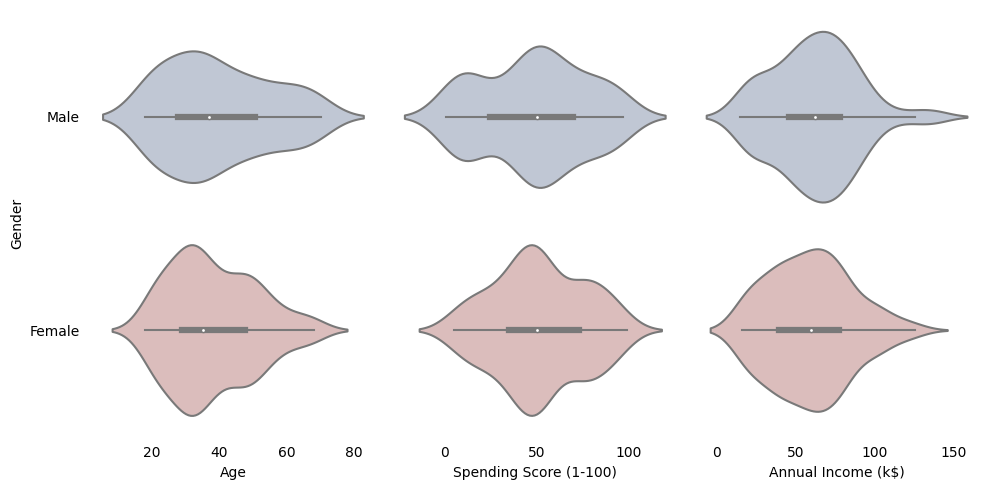

In [9]:
figure, axis = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    target_x = targets[i]
    vio_p = sns.violinplot(data=data, x=target_x, y='Gender', 
                           palette='vlag', ax=axis[i])
    
    sns.despine(bottom = True, left = True) # remove borders
    vio_p.tick_params(bottom=False, left = False) # remove ticks
    if i > 0 : # remove ylables for the 2nd and 3rd graphs
        vio_p.set(ylabel=None, yticklabels=[])

plt.tight_layout()
plt.show()

---
<b>Kmeans-clustering<b>

In [10]:
def kmeans_2Dclusters(features, xlabel, ylabel):
    # Determine number of clusters
    sse = []
    for n in range(1, 11):
        kmeans = KMeans(init='k-means++', n_clusters=n, n_init=10, 
                        max_iter=300, random_state=50)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
            
    sse_ncluster = pd.DataFrame({'SSE': sse, 'No. of clusters': range(1, 11)})
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.lineplot(data=sse_ncluster, x='No. of clusters', y='SSE', marker='o', ax=ax)
    n_clusters = KneeLocator(range(1, 11), sse, curve="convex", 
                             direction="decreasing").elbow
    plt.show()
    
    # Plot K-Means clusters
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, 
                        max_iter=300, random_state=50)
    kmeans.fit(features)
    label = kmeans.labels_
    centroids = kmeans.cluster_centers_


    h = 0.02
    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(1)

    plt.imshow(Z, interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired, aspect="auto", origin="lower")
    plt.scatter(features[:, 0], features[:, 1], c=label)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', alpha = 0.5)

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


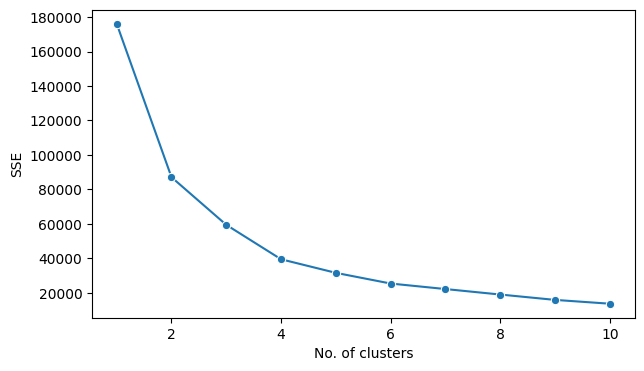

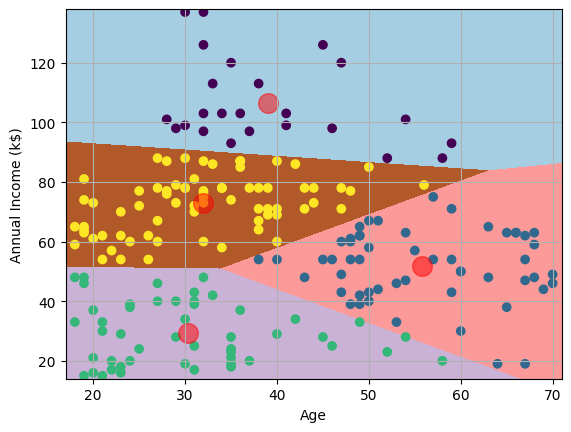

In [11]:
features = data.iloc[:,2:4].values
kmeans_2Dclusters(features, 'Age', 'Annual Income (k$)')

There are four clusters for Age & Annual Income (k$):
- low income for all ages
- medium income and younger people
- medium income and older people
- high income for all ages

We could send different types of promotion email to customers according to the clustering results.

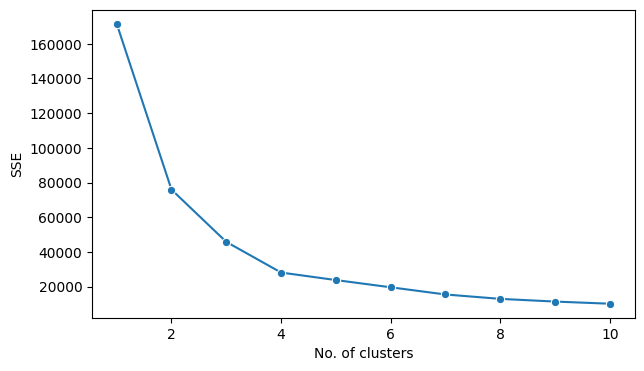

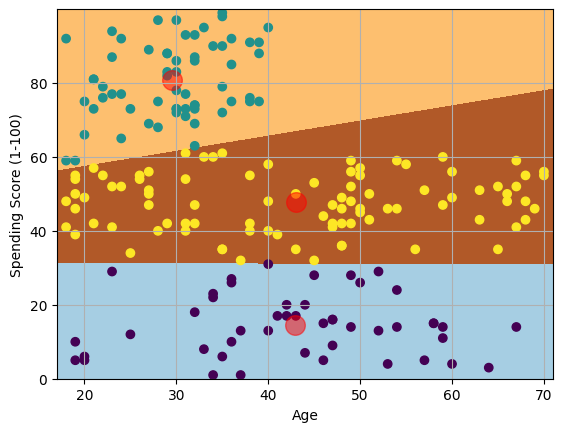

In [12]:
features = data.iloc[:,[2,4]].values
kmeans_2Dclusters(features, 'Age', 'Spending Score (1-100)')

These three clusters for Age & Spending Score (1-100) are generallly based on the spending scores. 

We could arrange the email frequencies for different customers according to the results.

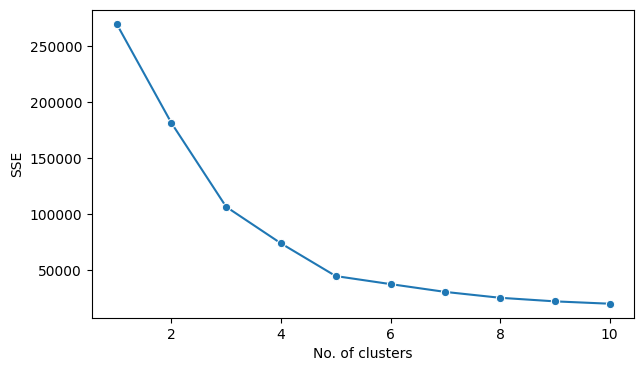

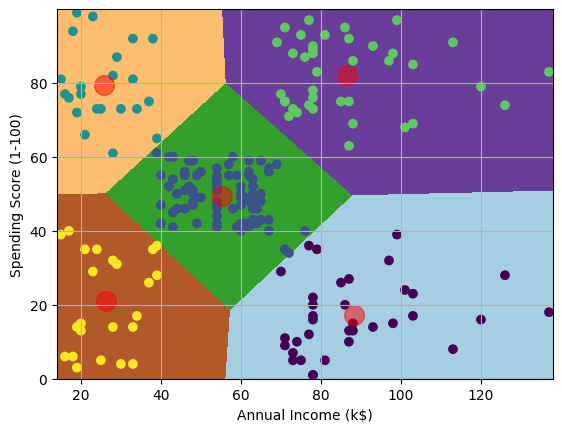

In [13]:
features = data.iloc[:,3:5].values
kmeans_2Dclusters(features, 'Annual Income (k$)', 'Spending Score (1-100)')

There are five clusters for Annual Income (k$) & Spending Score (1-100):
- low income with less spending desires
- low income with greater spending desires
- medium income and spending desires
- high income with less spending desires
- high income with greater spending desires

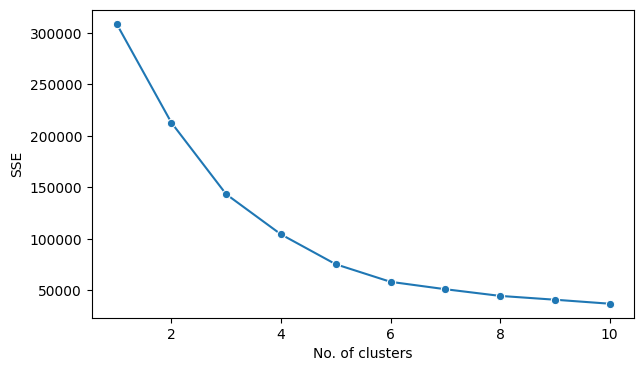

In [14]:
features = data[['Age', 'Annual Income (k$)', 
                 'Spending Score (1-100)']].iloc[:,:].values

# Determine number of clusters
sse = []
for n in range(1, 11):
    kmeans = KMeans(init='k-means++', n_clusters=n, n_init=10, 
                    max_iter=300, random_state=50)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)
            
sse_ncluster = pd.DataFrame({'SSE': sse, 'No. of clusters': range(1, 11)})
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(data=sse_ncluster, x='No. of clusters', y='SSE', marker='o', ax=ax)
n_clusters = KneeLocator(range(1, 11), sse, curve="convex", 
                         direction="decreasing").elbow
plt.show()
    
# Plot K-Means clusters
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, 
                    max_iter=300, random_state=50)
kmeans.fit(features)
label = kmeans.labels_
centroids = kmeans.cluster_centers_


In [15]:
fig = go.Figure(data=[go.Scatter3d(x=data['Age'], y=data['Annual Income (k$)'], 
                                   z=data['Spending Score (1-100)'],
                                   mode='markers', 
                                   marker=dict(color=label, opacity=0.7))])

fig.update_layout(
    # title='', 
    scene=dict(xaxis_title='Age',
               yaxis_title='Annual Income (k$)',
               zaxis_title='Spending Score (1-100)',),)

fig.show()

There are four clusters:
-  high income, high spending desire and younger people
-  high income, low spending desire for all ages
-  low income, high spending desire and younger people
-  low income and low spending desire for all ages